# Collecting exit relay data

Relay properties we're collecting:
- __Fingerprint__: relay unique identifier
- __Bandwidth__: observed bandwidth
- __Age__: # seconds since this relay was first seen
- __Family Size__: number of relays reported in effective family
- __AS__: the autonomous system this relay belongs to
- __Uptime__: time since last restart of this relay
- __Consensus Weight__: weight as a fraction of the whole network
- __Port/Address uptime__: time since relay changed its port or address
- __Country__: the country this relay is located in
- __Ports accepted__: the number of ports this relay accepts connections on

We also collect which flags are present in each relay description:
- __Exit__: Is it an exit relay? (always 1)
- __Fast__: Does it have a lot of bandwidth available?
- __Running__: Has it been online in the past 45 minutes?
- __Stable__: Is it suitable for long-lived circuits?
- __Guard__: Is it a guard relay?


*** IMPORTANT YOU MUST RUN THIS BLOCK TO GET THE NECESSARY IMPORTS AND HELPER METHODS ***

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import requests, datetime, statistics, math, json
import pandas as pd

import plotly.plotly as py
from plotly.graph_objs import *

onionoo_url = "https://onionoo.torproject.org/"

# Need this function to convert port-ranges into arrays
def mixrange(arr):
    r = []
    for i in arr:
        if '-' not in i:
            r.append(int(i))
        else:
            l,h = map(int, i.split('-'))
            r+= range(l,h+1)
    return r

# Need this function to compute the age of a given relay
def compute_age(relay):
    if not 'first_seen' in relay or not 'last_seen' in relay:
        return None
    first_seen = datetime.datetime.strptime(relay['first_seen'],"%Y-%m-%d %H:%M:%S")
    last_seen = datetime.datetime.strptime(relay['last_seen'],"%Y-%m-%d %H:%M:%S")
    age = (last_seen - first_seen).total_seconds()
    return age

def compute_open_ports(relay):
    if not 'exit_policy_summary' in relay:
        return None
    for policy in relay['exit_policy_summary']:
        if policy == 'accept':
            ports =  len(mixrange(relay['exit_policy_summary'][policy]))
        elif policy == 'reject':
            ports = 65535 - len(mixrange(relay['exit_policy_summary'][policy]))
    return ports

def compute_uptime(relay, pulled):
    if not 'last_restarted' in relay:
        return None
    last_restart = datetime.datetime.strptime(relay['last_restarted'],"%Y-%m-%d %H:%M:%S")
    return (pulled-last_restart).total_seconds()

def compute_addr_port_uptime(relay, pulled):
    if not 'last_changed_address_or_port' in relay:
        return None
    last_change = datetime.datetime.strptime(relay['last_changed_address_or_port'],"%Y-%m-%d %H:%M:%S")
    return (pulled-last_change).total_seconds()

def normalize(x):
    return (x - x.mean()) / (x.max() - x.min())

def log_normalize(df, columns):
    # Drop any 0's
    size = len(df)
    for col in columns:
        df = df[df[col]>0]
    print("Dropped %d rows."%(size-len(df)))
    
    for col in columns:
        df[col] = normalize(df[col].apply(lambda x: math.log(abs(x))))
    return df

def plot_feature(allDF, exitDF, guardDF, feature_x, feature_y):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.scatter(allDF[feature_x], allDF[feature_y], c='b', label='all',alpha=0.3)
    ax1.scatter(exitDF[feature_x], exitDF[feature_y], c='r', label='exit',alpha=0.3)
    ax1.scatter(guardDF[feature_x], guardDF[feature_y],c='g',label='guard',alpha=0.3)
    plt.legend(loc='upper left')
    plt.title("%s vs. %s"%(feature_x,feature_y))
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    fig.savefig('./images/%s_v_%s.png'%(feature_x,feature_y),dpi=1000)
    plt.show()

## Relay Details:

There are several ways to construct the relay data make sure to look and choose carefully before running any of the blocks below.

### Run this block to collect data using onionoo requests

This is good if you don't have any saved .json responses from Onionoo.org or if you just want to pull down a more recent response.

In [ ]:
# Used to filter the results so that they only contain these fields
url = onionoo_url+"details?limit=500&type=relay&flag=Exit"
response = requests.get(url).json()
print(response.status_code)

### Run this block to load data from a .json file

This is best if you already have a response from Onionoo.org that you'd like to use.

In [109]:
with open('sample-12-18-16.json') as json_data:
    response = json.load(json_data)

### Run this block to build the relay DataFrame

Whether you got the response from requests or by loading a .json, you need to run this to parse the json into a DataFrame object. 

In [ ]:
columns=['fingerprint',
         'nickname',
         'bandwidth',
         'age',
         'family_size',
         'as_number',
         'consensus_weight',
         'ports_accepted',
         'uptime',
         'address_port_uptime',
         'badexit',
         'exit',
         'fast',
         'guard',
         'hsdir',
         'stable',
         'running',
         'valid']

relayDF = pd.DataFrame(columns=columns)

for relay in response['relays']:
    row = [None]*len(columns)
    
    # IDENTIFIERS
    row[0] = relay['fingerprint'] if 'fingerprint' in relay else None
    row[1] = relay['nickname'] if 'nickname' in relay else None
    
    # NETWORK PROPERTIES
    row[2] = relay['advertised_bandwidth'] if 'advertised_bandwidth' in relay else None
    row[3] = compute_age(relay)
    row[4] = len(relay['effective_family']) if 'effective_family' in relay else None
    row[5] = relay['as_number'] if 'as_number' in relay else None
    row[6] = relay['consensus_weight_fraction'] if 'consensus_weight_fraction' in relay else None
    row[7] = compute_open_ports(relay)
    row[8] = compute_uptime(relay)
    row[9] = compute_addr_port_uptime(relay)
    
    # FLAGS
    if 'flags' in relay:
        row[10] = int('BadExit' in relay['flags'])
        row[11] = int('Exit' in relay['flags'])
        row[12] = int('Fast' in relay['flags'])
        row[13] = int('Guard' in relay['flags'])
        row[14] = int('HSDir' in relay['flags'])
        row[15] = int('Stable' in relay['flags'])
        row[16] = int('Running' in relay['flags'])
        row[17] = int('Valid' in relay['flags'])
    
    relayDF = relayDF.append(pd.DataFrame([row],columns=columns))
relayDF.reset_index(drop=True,inplace=True)
relayDF.head()

In [ ]:
# How many did we get?
len(relayDF)

#### VERSION 2.0 - MORE FIELDS

In [110]:
columns=['fingerprint',
         'nickname',
         'last_seen',
         'last_restarted',
         'last_changed_addr_port',
         'first_seen',
         'hibernating',
         'age', # computed from last_seen and first_seen
         'uptime', # computed from last_restarted and date pulled
         'address_port_uptime', # computed from last_changed_addr_port and date pulled
         'bandwidth_rate',
         'bandwidth_burst',
         'observed_bandwidth',
         'advertised_bandwidth',
         'consensus_weight',
         'ports_accepted',
         'country',
         'as_number',
         'effective_family',
         'indirect_family',
         'guard_prob',
         'middle_prob',
         'exit_prob',
         'badexit',
         'exit',
         'fast',
         'guard',
         'hsdir',
         'stable',
         'running',
         'valid',
         'v2dir']

relayDF = pd.DataFrame(columns=columns)

date_pulled = datetime.datetime.strptime(response['relays_published'],"%Y-%m-%d %H:%M:%S")

for relay in response['relays']:
    row = [None]*len(columns)
    
    # IDENTIFIERS
    row[0] = relay['fingerprint'] if 'fingerprint' in relay else None
    row[1] = relay['nickname'] if 'nickname' in relay else None
    
    # REPORTED TIMING PROPERTIES
    row[2] = relay['last_seen'] if 'last_seen' in relay else None
    row[3] = relay['last_restarted'] if 'last_restarted' in relay else None
    row[4] = relay['last_changed_address_or_port'] if 'last_changed_address_or_port' in relay else None
    row[5] = relay['first_seen'] if 'first_seen' in relay else None
    row[6] = 1 if 'hibernating' in relay else 0
    
    # COMPUTED TIMING PROPERTIES
    row[7] = compute_age(relay)
    row[8] = compute_uptime(relay, date_pulled)
    row[9] = compute_addr_port_uptime(relay, date_pulled)
    
    # BANDWIDTH PROPERTIES
    row[10] = relay['bandwidth_rate'] if 'bandwidth_rate' in relay else None
    row[11] = relay['bandwidth_burst'] if 'bandwidth_burst' in relay else None
    row[12] = relay['observed_bandwidth'] if 'observed_bandwidth' in relay else None
    row[13] = relay['advertised_bandwidth'] if 'advertised_bandwidth' in relay else None
    
    # CONSENSUS AND PORTS
    row[14] = relay['consensus_weight_fraction'] if 'consensus_weight_fraction' in relay else None
    row[15] = compute_open_ports(relay)
    
    # FAMILY PROPERTIES
    row[16] = relay['country'] if 'country' in relay else None
    row[17] = relay['as_number'] if 'as_number' in relay else None
    row[18] = len(relay['effective_family']) if 'effective_family' in relay else None
    row[19] = len(relay['indirect_family']) if 'indirect_family' in relay else None
    
    # POSITIONAL PROBABILITIES
    row[20] = relay['guard_probability'] if 'guard_probability' in relay else None
    row[21] = relay['middle_probability'] if 'middle_probability' in relay else None
    row[22] = relay['exit_probability'] if 'exit_probability' in relay else None
    
    # FLAGS
    if 'flags' in relay:
        row[23] = int('BadExit' in relay['flags'])
        row[24] = int('Exit' in relay['flags'])
        row[25] = int('Fast' in relay['flags'])
        row[26] = int('Guard' in relay['flags'])
        row[27] = int('HSDir' in relay['flags'])
        row[28] = int('Stable' in relay['flags'])
        row[29] = int('Running' in relay['flags'])
        row[30] = int('Valid' in relay['flags'])
        row[31] = int('V2Dir' in relay['flags'])
    
    relayDF = relayDF.append(pd.DataFrame([row],columns=columns))
relayDF.reset_index(drop=True,inplace=True)
relayDF.head()

,fingerprint,nickname,last_seen,last_restarted,last_changed_addr_port,first_seen,hibernating,age,uptime,address_port_uptime,...,exit_prob,badexit,exit,fast,guard,hsdir,stable,running,valid,v2dir
0,2B35CC60F043B3DB6DFFE73F464A67B82B0B0B4E,torjittertrapnet,2016-12-18 14:00:00,2016-12-08 08:30:31,2016-08-10 03:00:00,2016-08-10 03:00:00,0.0,11271600.0,883769.0,11271600.0,...,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
1,055A3CAA2582B87448301367ECD5905D138EF049,verax1,2016-12-18 14:00:00,2016-08-28 01:40:14,2016-08-28 02:00:00,2014-11-29 22:00:00,0.0,64771200.0,9721186.0,9720000.0,...,0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
2,D5F2C65F4131A1468D5B67A8838A9B7ED8C049E2,che,2016-12-18 14:00:00,2016-12-08 18:02:47,2016-06-20 14:00:00,2007-10-27 12:00:00,0.0,288583200.0,849433.0,15638400.0,...,6.33964e-06,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
3,0F69025EA0A61A96E5444A8BF39A8B1335488610,Uni25,2016-12-18 14:00:00,2016-11-28 23:11:16,2016-10-25 16:00:00,2015-04-24 21:00:00,0.0,52160400.0,1694924.0,4658400.0,...,0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
4,2A587ED761FB8CF8AA7CB77164455479C002141B,Unnamed,2016-12-18 14:00:00,2016-12-12 23:06:28,2016-12-12 23:00:00,2016-12-12 23:00:00,0.0,486000.0,485612.0,486000.0,...,0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0


In [111]:
len(relayDF)

8382

### Run this to save the relay DataFrame as a .csv

Make sure you change the name of the file or it will overwrite what's already there!

In [112]:
relayDF.to_csv('sample-12-18-16-v2dir.csv')

### Run this to load a relay dataframe from a .csv file

If you already have a parsed .csv representation of the Onionoo response, you can load it with this block.

In [21]:
relayDF = pd.DataFrame.from_csv('sample-12-18-16.csv')
relayDF.head()

,fingerprint,nickname,last_seen,last_restarted,last_changed_addr_port,first_seen,hibernating,age,uptime,address_port_uptime,...,middle_prob,exit_prob,badexit,exit,fast,guard,hsdir,stable,running,valid
0,2B35CC60F043B3DB6DFFE73F464A67B82B0B0B4E,torjittertrapnet,2016-12-18 14:00:00,2016-12-08 08:30:31,2016-08-10 03:00:00,2016-08-10 03:00:00,0.0,11271600.0,883769.0,11271600.0,...,0.000001,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
1,055A3CAA2582B87448301367ECD5905D138EF049,verax1,2016-12-18 14:00:00,2016-08-28 01:40:14,2016-08-28 02:00:00,2014-11-29 22:00:00,0.0,64771200.0,9721186.0,9720000.0,...,0.000028,0.000000,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0
2,D5F2C65F4131A1468D5B67A8838A9B7ED8C049E2,che,2016-12-18 14:00:00,2016-12-08 18:02:47,2016-06-20 14:00:00,2007-10-27 12:00:00,0.0,288583200.0,849433.0,15638400.0,...,0.000000,0.000006,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
3,0F69025EA0A61A96E5444A8BF39A8B1335488610,Uni25,2016-12-18 14:00:00,2016-11-28 23:11:16,2016-10-25 16:00:00,2015-04-24 21:00:00,0.0,52160400.0,1694924.0,4658400.0,...,0.000010,0.000000,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0
4,2A587ED761FB8CF8AA7CB77164455479C002141B,Unnamed,2016-12-18 14:00:00,2016-12-12 23:06:28,2016-12-12 23:00:00,2016-12-12 23:00:00,0.0,486000.0,485612.0,486000.0,...,0.000015,0.000000,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0


# Relay Feature Properties

Here we look at the distributions of the relay properties and try different spaces to look for normal distributions.

## Advertised Bandwidth Distribution

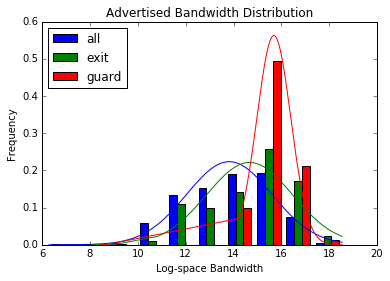

In [409]:
import scipy.stats as stats
fig = plt.figure()
ax1 = fig.add_subplot(111)
a = relayDF.advertised_bandwidth[relayDF.advertised_bandwidth>0].apply(lambda x: math.log(x))
e = relayDF.advertised_bandwidth[(relayDF.advertised_bandwidth>0)&(relayDF.exit==1)].apply(lambda x: math.log(x))
g = relayDF.advertised_bandwidth[(relayDF.advertised_bandwidth>0)&(relayDF.guard==1)].apply(lambda x: math.log(x))
ax1.hist((a,e,g),normed=True,label=['all','exit','guard'])
fit = stats.norm.pdf(a.sort_values(), a.mean(), a.std())
ax1.plot(a.sort_values(),fit,color='b')
fit = stats.norm.pdf(e.sort_values(), e.mean(), e.std())
ax1.plot(e.sort_values(),fit,color='g')
fit = stats.norm.pdf(g.sort_values(), g.mean(), g.std())
ax1.plot(g.sort_values(),fit,color='r')
plt.title("Advertised Bandwidth Distribution")
plt.ylabel("Frequency")
plt.xlabel("Log-space Bandwidth")
plt.legend(loc='upper left')
fig.savefig('./images/12-18-log_bandwidth_distribution',dpi=1000)
plt.show()

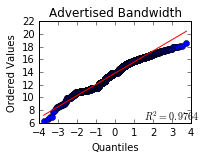

In [410]:
fig = plt.figure()
ax1 = fig.add_subplot(221)
x = relayDF[relayDF.advertised_bandwidth>0].advertised_bandwidth.apply(lambda x: math.log(x))
res = stats.probplot(x, plot=plt)
ax1.set_title("Advertised Bandwidth")
plt.show()

In [268]:
a.mean(),e.mean(),g.mean()

(13.821603721539171, 14.670205264031926, 15.68674609098163)

In [269]:
math.pow(a.std(),2)

3.1875756839413856

In [440]:
relayDF[(relayDF.guard==1)].advertised_bandwidth.std()/1000000

7.568681581995953

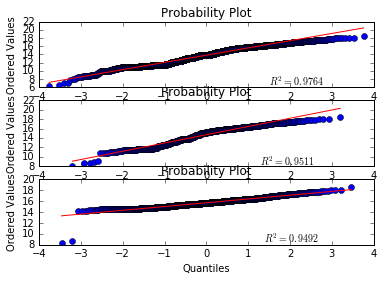

In [329]:
fig = plt.figure()
ax1 = fig.add_subplot(311)
x = relayDF[relayDF.advertised_bandwidth>0].advertised_bandwidth.apply(lambda x: math.log(x))
res = stats.probplot(x, plot=plt)
ax2 = fig.add_subplot(312)
x = relayDF[(relayDF.advertised_bandwidth>0)&(relayDF.exit==1)].advertised_bandwidth.apply(lambda x: math.log(x))
res = stats.probplot(x, plot=plt)
ax3 = fig.add_subplot(313)
x = relayDF[(relayDF.advertised_bandwidth>0)&(relayDF.guard==1)].advertised_bandwidth.apply(lambda x: math.log(x))
res = stats.probplot(x, plot=plt)
plt.show()

## Consensus Weight Distribution

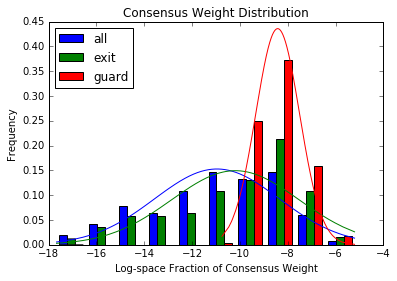

In [425]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
a = relayDF.consensus_weight[relayDF.consensus_weight>0].apply(lambda x: math.log(x))
e = relayDF.consensus_weight[(relayDF.consensus_weight>0)&(relayDF.exit==1)].apply(lambda x: math.log(x))
g = relayDF.consensus_weight[(relayDF.consensus_weight>0)&(relayDF.guard==1)].apply(lambda x: math.log(x))
ax1.hist((a,e,g),normed=True,label=['all','exit','guard'])
fit = stats.norm.pdf(a.sort_values(), a.mean(), a.std())
ax1.plot(a.sort_values(),fit,color='b')
fit = stats.norm.pdf(e.sort_values(), e.mean(), e.std())
ax1.plot(e.sort_values(),fit,color='g')
fit = stats.norm.pdf(g.sort_values(), g.mean(), g.std())
ax1.plot(g.sort_values(),fit,color='r')
plt.title("Consensus Weight Distribution")
plt.ylabel("Frequency")
plt.xlabel("Log-space Fraction of Consensus Weight")
plt.legend(loc='upper left')
fig.savefig('./images/12-18-log_consensus_distribution',dpi=1000)
plt.show()

In [296]:
relayDF.consensus_weight.mean(),relayDF[relayDF.exit==1].consensus_weight.mean(),relayDF[relayDF.guard==1].consensus_weight.mean()

(0.0001388696016257246, 0.0002440580011284369, 0.00034393339421295524)

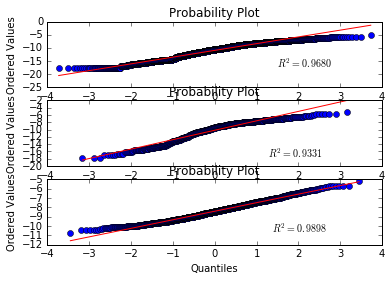

In [328]:
fig = plt.figure()
ax1 = fig.add_subplot(311)
x = relayDF[relayDF.consensus_weight>0].consensus_weight.apply(lambda x: math.log(x))
res = stats.probplot(x, plot=plt)
ax2 = fig.add_subplot(312)
x = relayDF[(relayDF.consensus_weight>0)&(relayDF.exit==1)].consensus_weight.apply(lambda x: math.log(x))
res = stats.probplot(x, plot=plt)
ax3 = fig.add_subplot(313)
x = relayDF[(relayDF.consensus_weight>0)&(relayDF.guard==1)].consensus_weight.apply(lambda x: math.log(x))
res = stats.probplot(x, plot=plt)
plt.show()

In [431]:
relayDF[(relayDF.consensus_weight>0)].consensus_weight.mean()*100

0.013900472634234681

## Bandwidth Discrepencies

There are several bandwdith values a relay can report. They are typically not the same. The smallest is used to determine consensus weight and therefore the most important with regards to a relay's likelihood of being chosen for a path.

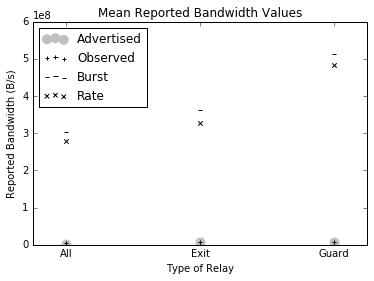

In [137]:
adv_mean = [relayDF.advertised_bandwidth.mean(),
            relayDF[relayDF.exit==1].advertised_bandwidth.mean(),
            relayDF[relayDF.guard==1].advertised_bandwidth.mean()]

obs_mean = [relayDF.observed_bandwidth.mean(),
            relayDF[relayDF.exit==1].observed_bandwidth.mean(),
            relayDF[relayDF.guard==1].observed_bandwidth.mean()]

burst_mean = [relayDF.bandwidth_burst.mean(),
              relayDF[relayDF.exit==1].bandwidth_burst.mean(),
              relayDF[relayDF.guard==1].bandwidth_burst.mean()]

rate_mean = [relayDF.bandwidth_rate.mean(),
             relayDF[relayDF.exit==1].bandwidth_rate.mean(),
             relayDF[relayDF.guard==1].bandwidth_rate.mean()]

x = [0,1,2]

plt.scatter(x, adv_mean, s=80, marker='o',label='Advertised',color='0.75')
plt.scatter(x, obs_mean, marker='+', label='Observed',color='k')
plt.scatter(x, burst_mean, marker='_', label='Burst',color='k')
plt.scatter(x, rate_mean, marker='x', label='Rate',color='k')
plt.xlabel('Type of Relay')
plt.ylabel('Reported Bandwidth (B/s)')
plt.title('Mean Reported Bandwidth Values')
plt.xlim(-0.25,2.25)
plt.ylim(ymin=0)
plt.legend(loc='upper left')
plt.xticks(x, ['All', 'Exit','Guard'])
plt.savefig('./images/12-18-reported_bandwidths',dpi=1000)
plt.show()

## Family Size

In [102]:
# Number of relays reporting a family size>0:
len(relayDF[relayDF.effective_family>0])

1379

In [104]:
# Number of relays reporting an indirect family size>0:
len(relayDF[(relayDF.indirect_family>0)&(relayDF.effective_family>0)])

99

In [131]:
relayDF[relayDF.effective_family>0].effective_family.std()

7.5165086222440189

In [132]:
relayDF[(relayDF.indirect_family>0)&(relayDF.effective_family>0)].indirect_family.std()

6.3428629928602946

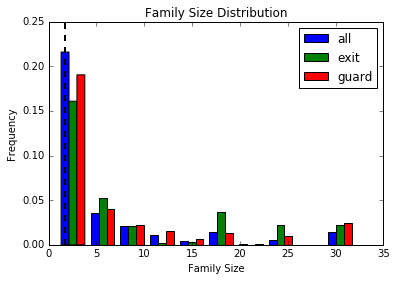

In [252]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
a = relayDF.effective_family[relayDF.effective_family>0]
e = relayDF.effective_family[(relayDF.effective_family>0)&(relayDF.exit==1)]
g = relayDF.effective_family[(relayDF.effective_family>0)&(relayDF.guard==1)]
ax1.hist((a,e,g),normed=True,label=['all','exit','guard'])
plt.axvline(math.log(relayDF[relayDF.effective_family>0].effective_family.mean()), color='k', linestyle='dashed', linewidth=2)
plt.title("Family Size Distribution")
plt.legend(loc='upper right')
plt.ylabel("Frequency")
plt.xlabel("Family Size")
fig.savefig('./images/12-18-family_size_distribution',dpi=1000)
plt.show()

## AS Number

In [173]:
# How many relays didn't report an AS?
count = 0
for num in relayDF.as_number:
    if num == None:
        count += 1
print(count)

56


## Flags

In [126]:
# Number of exit-only relays
len(relayDF[(relayDF.exit==1)&(relayDF.guard==0)])

573

In [127]:
# Number of guard-only relays
len(relayDF[(relayDF.guard==1)&(relayDF.exit==0)])

2123

In [128]:
# Number of exit-guard relays
len(relayDF[(relayDF.guard==1)&(relayDF.exit==1)])

458

In [129]:
# Number of non-exit, non-guard relays
len(relayDF[(relayDF.guard==0)&(relayDF.exit==0)])

5228

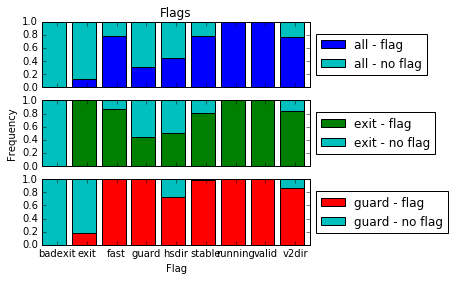

In [125]:
flags = ['badexit','exit','fast','guard','hsdir','stable','running','valid','v2dir']
countsA = [relayDF[flag].sum()/len(relayDF) for flag in flags]
countsE = [relayDF[relayDF.exit==1][flag].sum()/len(relayDF[relayDF.exit==1]) for flag in flags]
countsG = [relayDF[relayDF.guard==1][flag].sum()/len(relayDF[relayDF.guard==1]) for flag in flags]

negA = [1-x for x in countsA]
negE = [1-x for x in countsE]
negG = [1-x for x in countsG]

N=9
ind=np.arange(N)
width=1

fig = plt.figure()
fig, axarr = plt.subplots(3,1,sharex=True)
axarr[0].bar(ind,countsA,label='all',color='b')
axarr[0].bar(ind,negA,bottom=countsA,color='c')
axarr[1].bar(ind,countsE,label='all',color='g')
axarr[1].bar(ind,negE,bottom=countsE,color='c')
axarr[2].bar(ind,countsG,label='all',color='r')
axarr[2].bar(ind,negG,bottom=countsG,color='c')

plt.xlabel("Flag")
axarr[0].set_xticks(ind+0.5)
axarr[0].set_xticklabels(flags)
axarr[0].set_title('Flags')
axarr[1].set_ylabel("Frequency")
# Shrink current axis by 20%
box = axarr[0].get_position()
axarr[0].set_position([box.x0, box.y0, box.width * 0.8, box.height])
box = axarr[1].get_position()
axarr[1].set_position([box.x0, box.y0, box.width * 0.8, box.height])
box = axarr[2].get_position()
axarr[2].set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
axarr[0].legend(('all - flag','all - no flag'),loc='center left', bbox_to_anchor=(1, 0.5))
axarr[1].legend(('exit - flag','exit - no flag'),loc='center left', bbox_to_anchor=(1, 0.5))
lgd = axarr[2].legend(('guard - flag','guard - no flag'),loc='center left', bbox_to_anchor=(1, 0.5))

fig.savefig('./images/12-18-flags.png',dpi=1000,bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

## Ports Accepted

Default Exit Policy = blackblist

Reduced Exit Policy = whitelist

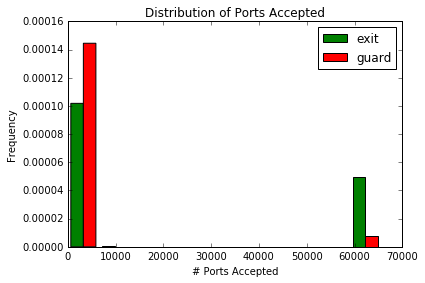

In [286]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
# a = relayDF.ports_accepted[(relayDF.exit==0)&(relayDF.guard==0)]
e = relayDF.ports_accepted[(relayDF.exit==1)]
g = relayDF.ports_accepted[(relayDF.guard==1)]
ax1.hist((e,g),normed=True,label=['exit','guard'],color=['g','r'])
plt.title("Distribution of Ports Accepted")
plt.legend(loc='upper right')
plt.ylabel("Frequency")
plt.xlabel("# Ports Accepted")
plt.tight_layout()
plt.savefig('./images/12-18-ports_accepted_distribution',dpi=1000)
plt.show()

## Timing Distributions

Age, uptime, addr/port uptime distributions.

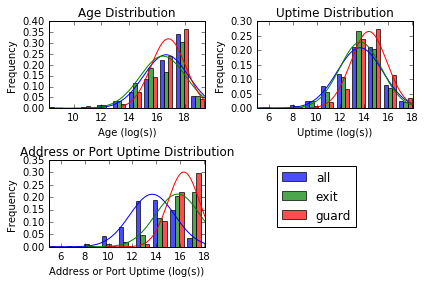

In [396]:
fig = plt.figure()
ax1 = fig.add_subplot(221)
a = relayDF[relayDF.age>0].age.apply(lambda x: math.log(x))
e = relayDF[relayDF.age>0].age[(relayDF.exit==1)].apply(lambda x: math.log(x))
g = relayDF[relayDF.age>0].age[(relayDF.guard==1)].apply(lambda x: math.log(x))
ax1.hist((a,e,g),normed=True,label=['all','exit','guard'],alpha=0.7)
fit = stats.norm.pdf(a.sort_values(), a.mean(), a.std())
ax1.plot(a.sort_values(),fit,color='b')
fit = stats.norm.pdf(e.sort_values(), e.mean(), e.std())
ax1.plot(e.sort_values(),fit,color='g')
fit = stats.norm.pdf(g.sort_values(), g.mean(), g.std())
ax1.plot(g.sort_values(),fit,color='r')
ax1.set_title("Age Distribution")
ax1.set_ylabel("Frequency")
ax1.set_xlabel("Age (log(s))")
ax1.set_xlim(xmin=a.min(),xmax=a.max())
ax1.set_ylim(ymin=0)

ax2 = fig.add_subplot(222)
a = relayDF[relayDF.uptime>0].uptime.apply(lambda x: math.log(x))
e = relayDF[relayDF.uptime>0].uptime[(relayDF.exit==1)].apply(lambda x: math.log(x))
g = relayDF[relayDF.uptime>0].uptime[(relayDF.guard==1)].apply(lambda x: math.log(x))
ax2.hist((a,e,g),normed=True,label=['all','exit','guard'],alpha=0.7)
fit = stats.norm.pdf(a.sort_values(), a.mean(), a.std())
ax2.plot(a.sort_values(),fit,color='b')
fit = stats.norm.pdf(e.sort_values(), e.mean(), e.std())
ax2.plot(e.sort_values(),fit,color='g')
fit = stats.norm.pdf(g.sort_values(), g.mean(), g.std())
ax2.plot(g.sort_values(),fit,color='r')
ax2.set_title("Uptime Distribution")
ax2.set_ylabel("Frequency")
ax2.set_xlabel("Uptime (log(s))")
ax2.set_xlim(xmin=a.min(),xmax=a.max())
ax2.set_ylim(ymin=0)

ax3 = fig.add_subplot(223)
a = relayDF[relayDF.address_port_uptime>0].uptime.apply(lambda x: math.log(x))
e = relayDF[relayDF.address_port_uptime>0].address_port_uptime[(relayDF.exit==1)].apply(lambda x: math.log(x))
g = relayDF[relayDF.address_port_uptime>0].address_port_uptime[(relayDF.guard==1)].apply(lambda x: math.log(x))
ax3.hist((a,e,g),normed=True,label=['all','exit','guard'],alpha=0.7)
fit = stats.norm.pdf(a.sort_values(), a.mean(), a.std())
ax3.plot(a.sort_values(),fit,color='b')
fit = stats.norm.pdf(e.sort_values(), e.mean(), e.std())
ax3.plot(e.sort_values(),fit,color='g')
fit = stats.norm.pdf(g.sort_values(), g.mean(), g.std())
ax3.plot(g.sort_values(),fit,color='r')
ax3.set_title("Address or Port Uptime Distribution")
ax3.set_ylabel("Frequency")
ax3.set_xlabel("Address or Port Uptime (log(s))")
ax3.set_xlim(xmin=a.min(),xmax=a.max())
ax3.set_ylim(ymin=0)

plt.legend(bbox_to_anchor=(2, 1))
plt.tight_layout()
# plt.savefig('./images/12-18-log-norm_age_distribution',dpi=1000)
plt.show()

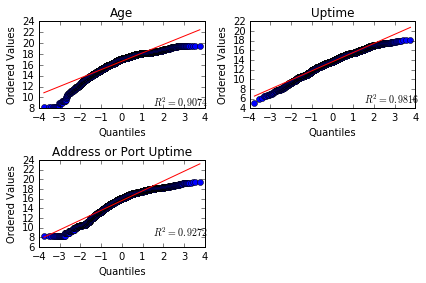

In [407]:
fig = plt.figure()
ax1 = fig.add_subplot(221)
x = relayDF[relayDF.age>0].age.apply(lambda x: math.log(x))
res = stats.probplot(x, plot=plt)
ax1.set_title("Age")
ax2 = fig.add_subplot(222)
x = relayDF[(relayDF.uptime>0)].uptime.apply(lambda x: math.log(x))
res = stats.probplot(x, plot=plt)
ax2.set_title("Uptime")
ax3 = fig.add_subplot(223)
x = relayDF[(relayDF.address_port_uptime>0)].address_port_uptime.apply(lambda x: math.log(x))
res = stats.probplot(x, plot=plt)
ax3.set_title("Address or Port Uptime")
plt.tight_layout()
plt.savefig("./images/12-18-goodness-timing-fit",dpi=1000)
plt.show()

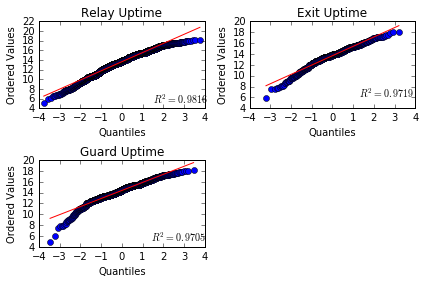

In [341]:
fig = plt.figure()
ax1 = fig.add_subplot(221)
x = relayDF[relayDF.uptime>0].uptime.apply(lambda x: math.log(x))
res = stats.probplot(x, plot=plt)
ax2 = fig.add_subplot(222)
x = relayDF[(relayDF.uptime>0)&(relayDF.exit==1)].uptime.apply(lambda x: math.log(x))
res = stats.probplot(x, plot=plt)
ax3 = fig.add_subplot(223)
x = relayDF[(relayDF.uptime>0)&(relayDF.guard==1)].uptime.apply(lambda x: math.log(x))
res = stats.probplot(x, plot=plt)
ax1.set_title('Relay Uptime')
ax2.set_title('Exit Uptime')
ax3.set_title('Guard Uptime')
plt.tight_layout()
plt.savefig('./images/12-18-log_uptime_normality_plot',dpi=1000)
plt.show()

# Bandwidth change over time

Collect bandwidth data for 500 relays. Store exit and non-exit separately. Plot bandwidth and time.


TODO: get stdev of bandwidth over time for exit and non-exit relays and compare.

In [ ]:
with open('bw_sample_ALL.json') as json_data:
    resp_all = json.load(json_data)
    
with open('bw_sample_exitflag.json') as json_data:
    resp_exit = json.load(json_data)

with open('bw_sample_Guard.json') as json_data:
    resp_guard = json.load(json_data)

In [ ]:
samples = {'3_days':{'exit':[],'all':[], 'guard':[]},
           '1_week':{'exit':[],'all':[], 'guard':[]},
           '1_month':{'exit':[],'all':[], 'guard':[]},
           '3_months':{'exit':[],'all':[], 'guard':[]},
           '1_year':{'exit':[],'all':[], 'guard':[]},
           '5_years':{'exit':[],'all':[], 'guard':[]}}

for relay in resp_all['relays']:
    if not 'write_history' in relay:
        pass
    else:
        for history in relay['write_history']:
            samples[history]['all'].append(relay['write_history'][history]['values'][:10])
        
for relay in resp_exit['relays']:
    if not 'write_history' in relay:
        pass
    else:
        for history in relay['write_history']:
            samples[history]['exit'].append(relay['write_history'][history]['values'][:10])
            
for relay in resp_guard['relays']:
    if not 'write_history' in relay:
        pass
    else:
        for history in relay['write_history']:
            samples[history]['guard'].append(relay['write_history'][history]['values'][:10])

In [ ]:
allBW = pd.DataFrame()
for entry in samples['5_years']['all']:
    allBW = allBW.append(pd.DataFrame([entry]))
allBW = allBW.transpose()
allBW['mean'] = allBW.mean(axis=1)
allBW

In [ ]:
exitBW = pd.DataFrame()
for entry in samples['5_years']['exit']:
    exitBW = exitBW.append(pd.DataFrame([entry]))
exitBW = exitBW.transpose()
exitBW['mean'] = exitBW.mean(axis=1)
exitBW.head()

In [ ]:
guardBW = pd.DataFrame()
for entry in samples['5_years']['guard']:
    guardBW = guardBW.append(pd.DataFrame([entry]))
guardBW = guardBW.transpose()
guardBW['mean'] = guardBW.mean(axis=1)
guardBW

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
x = [i*10 for i in range(0,10)]
ax1.plot(x, exitBW['mean'], c='b', marker="s", label='exit')
ax1.plot(x, allBW['mean'], c='r', marker="o", label='all')
ax1.plot(x, guardBW['mean'], c='g', marker="v", label='guard')
plt.legend(loc='lower right')
plt.title('Bandwidth')
plt.xlabel('Time (days)')
plt.ylabel('Bandwidth')
fig.savefig('./images/time_bandwidth.png', dpi=1000)
plt.show()

# Correlations

Looking for correlation between the data

In [ ]:
logDF = log_normalize(relayDF,['bandwidth','consensus_weight'])
# logDF = relayDF.copy()
# logDF = logDF[(logDF.bandwidth>0)&(logDF.consensus_weight>0)]
# logDF.bandwidth = logDF.bandwidth.apply(lambda x: math.log(x))
# logDF.consensus_weight = logDF.consensus_weight.apply(lambda x: math.log(x))
A = logDF[(logDF.guard==0)&(logDF.exit==0)]
E = logDF[logDF.exit==1]
G = logDF[logDF.guard==1]
plot_feature(A,E,G,'bandwidth','consensus_weight')

In [ ]:
# logDF = log_normalize(relayDF,['bandwidth','uptime'])
logDF = relayDF.copy()
logDF = logDF[(logDF.bandwidth>0)&(logDF.uptime>0)]
logDF.bandwidth = logDF.bandwidth.apply(lambda x: math.log(x))
logDF.uptime = logDF.uptime.apply(lambda x: math.log(x))
A = logDF[(logDF.guard==0)&(logDF.exit==0)]
E = logDF[logDF.exit==1]
G = logDF[logDF.guard==1]
plot_feature(A,E,G,'bandwidth','uptime')

In [ ]:
logDF = log_normalize(relayDF,['bandwidth','age'])
# logDF = relayDF.copy()
# logDF = logDF[(logDF.bandwidth>0)&(logDF.consensus_weight>0)]
# logDF.bandwidth = logDF.bandwidth.apply(lambda x: math.log(x))
# logDF.consensus_weight = logDF.consensus_weight.apply(lambda x: math.log(x))
A = logDF[(logDF.guard==0)&(logDF.exit==0)]
E = logDF[logDF.exit==1]
G = logDF[logDF.guard==1]
plot_feature(A,E,G,'bandwidth','age')

In [ ]:
logDF = log_normalize(relayDF,['bandwidth','ports_accepted'])
A = logDF[(logDF.guard==0)&(logDF.exit==0)]
E = logDF[logDF.exit==1]
G = logDF[logDF.guard==1]
plot_feature(A,E,G,'bandwidth','ports_accepted')

In [ ]:
logDF = log_normalize(relayDF,['bandwidth'])
A = logDF[(logDF.guard==0)&(logDF.exit==0)]
E = logDF[logDF.exit==1]
G = logDF[logDF.guard==1]
plot_feature(A,E,G,'bandwidth','family_size')

In [ ]:
# logDF = log_normalize(relayDF,['family_size','age'])
A = relayDF[(relayDF.guard==0)&(relayDF.exit==0)]
E = relayDF[relayDF.exit==1]
G = relayDF[relayDF.guard==1]
plot_feature(A,E,G,'family_size','age')

# Machine Learning

Here we use regression models to predict lifespans and classification models to classify relays as either exit or non-exit.

In [2]:
relayDF = pd.DataFrame.from_csv('sample-12-18-16-v2dir.csv')
print(relayDF.shape)
relayDF.head()

(8382, 32)


,fingerprint,nickname,last_seen,last_restarted,last_changed_addr_port,first_seen,hibernating,age,uptime,address_port_uptime,...,exit_prob,badexit,exit,fast,guard,hsdir,stable,running,valid,v2dir
0,2B35CC60F043B3DB6DFFE73F464A67B82B0B0B4E,torjittertrapnet,2016-12-18 14:00:00,2016-12-08 08:30:31,2016-08-10 03:00:00,2016-08-10 03:00:00,0.0,11271600.0,883769.0,11271600.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
1,055A3CAA2582B87448301367ECD5905D138EF049,verax1,2016-12-18 14:00:00,2016-08-28 01:40:14,2016-08-28 02:00:00,2014-11-29 22:00:00,0.0,64771200.0,9721186.0,9720000.0,...,0.000000,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
2,D5F2C65F4131A1468D5B67A8838A9B7ED8C049E2,che,2016-12-18 14:00:00,2016-12-08 18:02:47,2016-06-20 14:00:00,2007-10-27 12:00:00,0.0,288583200.0,849433.0,15638400.0,...,0.000006,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
3,0F69025EA0A61A96E5444A8BF39A8B1335488610,Uni25,2016-12-18 14:00:00,2016-11-28 23:11:16,2016-10-25 16:00:00,2015-04-24 21:00:00,0.0,52160400.0,1694924.0,4658400.0,...,0.000000,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
4,2A587ED761FB8CF8AA7CB77164455479C002141B,Unnamed,2016-12-18 14:00:00,2016-12-12 23:06:28,2016-12-12 23:00:00,2016-12-12 23:00:00,0.0,486000.0,485612.0,486000.0,...,0.000000,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0


# Classification

In [42]:
relayDF = pd.DataFrame.from_csv('sample-12-18-16-v2dir.csv')
print(relayDF.shape)
relayDF.head()

(8382, 32)


,fingerprint,nickname,last_seen,last_restarted,last_changed_addr_port,first_seen,hibernating,age,uptime,address_port_uptime,...,exit_prob,badexit,exit,fast,guard,hsdir,stable,running,valid,v2dir
0,2B35CC60F043B3DB6DFFE73F464A67B82B0B0B4E,torjittertrapnet,2016-12-18 14:00:00,2016-12-08 08:30:31,2016-08-10 03:00:00,2016-08-10 03:00:00,0.0,11271600.0,883769.0,11271600.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
1,055A3CAA2582B87448301367ECD5905D138EF049,verax1,2016-12-18 14:00:00,2016-08-28 01:40:14,2016-08-28 02:00:00,2014-11-29 22:00:00,0.0,64771200.0,9721186.0,9720000.0,...,0.000000,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
2,D5F2C65F4131A1468D5B67A8838A9B7ED8C049E2,che,2016-12-18 14:00:00,2016-12-08 18:02:47,2016-06-20 14:00:00,2007-10-27 12:00:00,0.0,288583200.0,849433.0,15638400.0,...,0.000006,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
3,0F69025EA0A61A96E5444A8BF39A8B1335488610,Uni25,2016-12-18 14:00:00,2016-11-28 23:11:16,2016-10-25 16:00:00,2015-04-24 21:00:00,0.0,52160400.0,1694924.0,4658400.0,...,0.000000,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
4,2A587ED761FB8CF8AA7CB77164455479C002141B,Unnamed,2016-12-18 14:00:00,2016-12-12 23:06:28,2016-12-12 23:00:00,2016-12-12 23:00:00,0.0,486000.0,485612.0,486000.0,...,0.000000,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0


In [43]:
log_cols = ['uptime','address_port_uptime','advertised_bandwidth','consensus_weight']
df = relayDF.copy()
df = df[(df.uptime>0)&(df.address_port_uptime>0)&(df.advertised_bandwidth>0)&(df.consensus_weight>0)]
# for col in log_cols:
#     df[col] = df[col].apply(lambda x: math.log(x))
# print(df.shape)

In [44]:
label = 'guard'
feats = ['advertised_bandwidth',
         'fast',
         'exit',
         'age',
         'stable',
         'v2dir',
#          'family_size',
         'consensus_weight',
         'ports_accepted',
         'uptime',
         'address_port_uptime']

# Remove NaN feature rows
for feat in feats:
    df = df[np.isfinite(df[feat])]
print(df.shape)

(7158, 32)


In [41]:
for feat in feats:
    df[feat] = normalize(df[feat])

In [465]:
# If it's an odd length, we need to drop one entry before splitting
df = df[:-1]
print(df.shape)

(7157, 32)


In [45]:
# Split our data in half. We train on 50% and test on the other 50%.
# There's definitely better ways to split to make sure we get even
# distribution of elements but this is good enough for now.

# Labels
Y_all = np.asarray(df[label])
Y_train, Y_test = np.split(Y_all,2)

# Features
X_all = df[feats].as_matrix()
X_train, X_test = np.split(X_all,2)

### Here's a look at what we end up with:

In [46]:
Y_train.shape,Y_test.shape

((3579,), (3579,))

In [47]:
X_train.shape,X_test.shape

((3579, 10), (3579, 10))

## K-Nearest Neighbours

In [27]:
# Pick k based on average family size
df.effective_family.mean(), df.effective_family.max(), statistics.stdev(df.effective_family[np.isfinite(df.effective_family)])

(5.558411214953271, 32.0, 7.509236669180393)

In [28]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

scores = []

for k in range(1,32):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train,Y_train)
    Y_pred = model.predict(X_test)
    scores.append((k,accuracy_score(Y_test,Y_pred, normalize=True)))
    
print(max(scores,key=lambda item:item[1]))

(26, 0.94300083822296732)


## Logistic Regression

In [29]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train,Y_train)
Y_pred = model.predict(X_test)
accuracy_score(Y_test,Y_pred, normalize=True)

0.93797150041911148

## Naive Bayes

In [30]:
from sklearn.naive_bayes import BernoulliNB

model = BernoulliNB()
model.fit(X_train,Y_train)
Y_pred = model.predict(X_test)
accuracy_score(Y_test,Y_pred, normalize=True)

0.90108968985750204

In [31]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(X_train,Y_train)
Y_pred = model.predict(X_test)
accuracy_score(Y_test,Y_pred, normalize=True)

0.72562168203408772

## Decision Tree

In [48]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(X_train,Y_train)
Y_pred = model.predict(X_test)
accuracy_score(Y_test,Y_pred, normalize=True)

0.93182453199217663

## Random Forest

This one allows us to get the features that had the biggest impact on decision making.

In [57]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train,Y_train)
Y_pred = model.predict(X_test)
accuracy_score(Y_test,Y_pred, normalize=True)

0.95250069851913943

In [58]:
imp = model.feature_importances_

feat_wt = [(feats[i],imp[i]) for i in range(len(imp))]
feat_wt = sorted(feat_wt, key=lambda x: x[1])

In [59]:
print(imp)
print(feats)

[ 0.55197606  0.03198492  0.00191007  0.03460119  0.04428406  0.00836103
  0.224541    0.00952945  0.05602123  0.03679099]
['advertised_bandwidth', 'fast', 'exit', 'age', 'stable', 'v2dir', 'consensus_weight', 'ports_accepted', 'uptime', 'address_port_uptime']


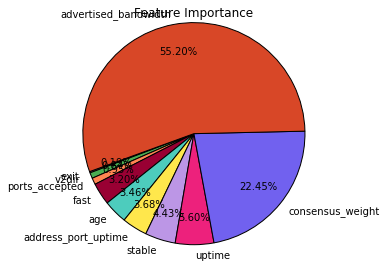

In [60]:
colors = ['#EB7BC0',
          '#4AAD52',
          '#FF8552',
          '#990033',
          '#4DCCBD',
          '#FFE74C',
          '#BC96E6',
          '#ED217C',
          '#7161EF',
          '#D84727']
plt.pie([i[1] for i in feat_wt],
        labels=[i[0] for i in feat_wt],
        shadow=False,
        autopct='%1.2f%%',
        startangle=200,
        pctdistance=0.75,
        labeldistance=1.1,
        colors=colors[:len(imp)])
plt.axis('equal')
plt.title("Feature Importance")
plt.savefig('./images/feature_importance.png',dpi=1000)
plt.show()

In [61]:
scores = []
for i in range(2,10):
    for j in range(2,10):
        estimator = DecisionTreeClassifier(max_depth=i,max_leaf_nodes=j)
        estimator.fit(X_train, Y_train)
        Y_pred = estimator.predict(X_test)
        scores.append((i,j,accuracy_score(Y_test,Y_pred, normalize=True)))
print(max(scores,key=lambda item:item[2]))

(3, 6, 0.95529477507683713)


In [62]:
estimator = DecisionTreeClassifier(max_depth=4,max_leaf_nodes=8)
estimator.fit(X_train, Y_train)

# The decision estimator has an attribute called tree_  which stores the entire
# tree structure and allows access to low level attributes. The binary tree
# tree_ is represented as a number of parallel arrays. The i-th element of each
# array holds information about the node `i`. Node 0 is the tree's root. NOTE:
# Some of the arrays only apply to either leaves or split nodes, resp. In this
# case the values of nodes of the other type are arbitrary!
#
# Among those arrays, we have:
#   - left_child, id of the left child of the node
#   - right_child, id of the right child of the node
#   - feature, feature used for splitting the node
#   - threshold, threshold value at the node
#

# Using those arrays, we can parse the tree structure:

n_nodes = estimator.tree_.node_count
children_left = estimator.tree_.children_left
children_right = estimator.tree_.children_right
feature = estimator.tree_.feature
threshold = estimator.tree_.threshold


# The tree structure can be traversed to compute various properties such
# as the depth of each node and whether or not it is a leaf.
node_depth = np.zeros(shape=n_nodes)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)]  # seed is the root node id and its parent depth
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    # If we have a test node
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True

print("The binary tree structure has %s nodes and has "
      "the following tree structure:"
      % n_nodes)
for i in range(n_nodes):
    if is_leaves[i]:
        print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
    else:
        print("%snode=%s test node: go to node %s if X[:, %s] <= %ss else to "
              "node %s."
              % (node_depth[i] * "\t",
                 i,
                 children_left[i],
                 feature[i],
                 threshold[i],
                 children_right[i],
                 ))
print()

# First let's retrieve the decision path of each sample. The decision_path
# method allows to retrieve the node indicator functions. A non zero element of
# indicator matrix at the position (i, j) indicates that the sample i goes
# through the node j.

node_indicator = estimator.decision_path(X_test)

# Similarly, we can also have the leaves ids reached by each sample.

leave_id = estimator.apply(X_test)

# Now, it's possible to get the tests that were used to predict a sample or
# a group of samples. First, let's make it for the sample.

sample_id = 0
node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                    node_indicator.indptr[sample_id + 1]]

print('Rules used to predict sample %s: ' % sample_id)
for node_id in node_index:
    if leave_id[sample_id] != node_id:
        continue

    if (X_test[sample_id, feature[node_id]] <= threshold[node_id]):
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print("decision id node %s : (X[%s, %s] (= %s) %s %s)"
          % (node_id,
             sample_id,
             feature[node_id],
             X_test[i, feature[node_id]],
             threshold_sign,
             threshold[node_id]))

# For a group of samples, we have the following common node.
sample_ids = [0, 1]
common_nodes = (node_indicator.toarray()[sample_ids].sum(axis=0) ==
                len(sample_ids))

common_node_id = np.arange(n_nodes)[common_nodes]

print("\nThe following samples %s share the node %s in the tree"
      % (sample_ids, common_node_id))
print("It is %s %% of all nodes." % (100 * len(common_node_id) / n_nodes,))

The binary tree structure has 15 nodes and has the following tree structure:
node=0 test node: go to node 1 if X[:, 0] <= 2095888.5s else to node 2.
	node=1 test node: go to node 7 if X[:, 6] <= 6.12003641436e-05s else to node 8.
	node=2 test node: go to node 3 if X[:, 4] <= 0.5s else to node 4.
		node=3 leaf node.
		node=4 test node: go to node 5 if X[:, 6] <= 4.13314992329e-05s else to node 6.
			node=5 leaf node.
			node=6 test node: go to node 9 if X[:, 3] <= 703800.0s else to node 10.
		node=7 leaf node.
		node=8 test node: go to node 13 if X[:, 8] <= 800265.0s else to node 14.
				node=9 leaf node.
				node=10 test node: go to node 11 if X[:, 8] <= 1700039.5s else to node 12.
					node=11 leaf node.
					node=12 leaf node.
			node=13 leaf node.
			node=14 leaf node.

Rules used to predict sample 0: 
decision id node 7 : (X[0, -2] (= 28880900.0) > -2.0)

The following samples [0, 1] share the node [0 1 7] in the tree
It is 20.0 % of all nodes.


/Users/cassiancorey/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:52: DeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future

/Users/cassiancorey/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:48: DeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



In [27]:
estimator.apply([X_train[1]])

array([12])

In [28]:
Y_train[1]

1.0